# Bone Fracture Detection Using MURA Dataset

## Import Libraries

In [6]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog, local_binary_pattern
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [7]:
BASE_PATH = r'c:\Users\user\Desktop\DIP Project\MURA-v1.1'
IMAGE_SIZE = (128, 128)

## Data Preprocessing Functions

In [8]:
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img

## Preprocessing Steps Visualization

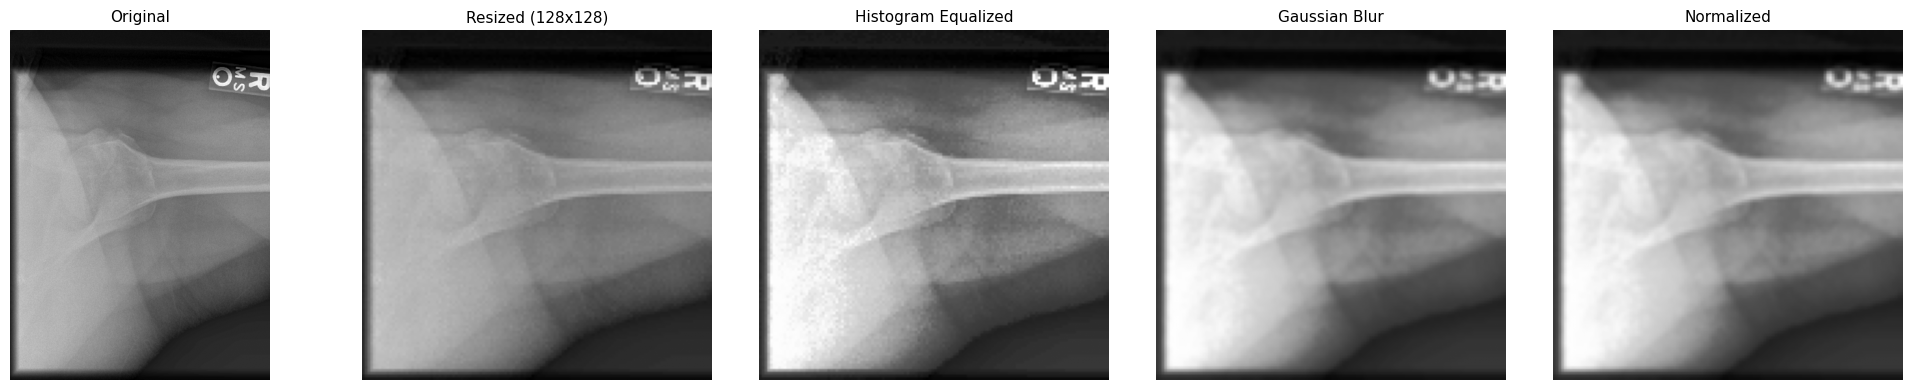

In [9]:
if 'train_labels_path' not in globals():
    train_labels_path = os.path.join(BASE_PATH, 'train_labeled_studies.csv')
if 'train_images_path' not in globals():
    train_images_path = os.path.join(BASE_PATH, 'train_image_paths.csv')

sample_img_path = None
for _, row in pd.read_csv(train_labels_path, header=None, names=['study','label']).head(50).iterrows():
    study_path = row['study'].rstrip('/')
    df_images = pd.read_csv(train_images_path, header=None, names=['path'])
    study_images = df_images[df_images['path'].str.startswith(study_path)]
    if len(study_images) > 0:
        img_path = study_images['path'].iloc[0]
        if img_path.startswith('MURA-v1.1/'):
            img_path = img_path.replace('MURA-v1.1/', '', 1)
        full_path = os.path.join(BASE_PATH, img_path.replace('/', os.sep))
        if os.path.exists(full_path):
            sample_img_path = full_path
            break

if sample_img_path:
    original = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
    step1_resize = cv2.resize(original, IMAGE_SIZE)
    step2_equalize = cv2.equalizeHist(step1_resize)
    step3_blur = cv2.GaussianBlur(step2_equalize, (3, 3), 0)
    step4_normalize = cv2.normalize(step3_blur, None, 0, 255, cv2.NORM_MINMAX)
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    images = [original, step1_resize, step2_equalize, step3_blur, step4_normalize]
    titles = ['Original', 'Resized (128x128)', 'Histogram Equalized', 'Gaussian Blur', 'Normalized']
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title, fontsize=11)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_steps.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('No sample image found')

## Feature Extraction Functions

In [10]:
def extract_hog_features(img):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2), visualize=False)
    return features

## Dataset Loading

In [11]:
def load_dataset(image_paths_file, labeled_studies_file):
    df_images = pd.read_csv(image_paths_file, header=None, names=['path'])
    df_labels = pd.read_csv(labeled_studies_file, header=None, names=['study', 'label'])
    
    data = []
    labels = []
    
    print(f"Loading images...")
    
    for _, row in tqdm(df_labels.iterrows(), total=len(df_labels)):
        study_path = row['study'].rstrip('/')
        label = row['label']
        
        study_images = df_images[df_images['path'].str.startswith(study_path)]
        
        for img_path in study_images['path']:
            if img_path.startswith('MURA-v1.1/'):
                img_path = img_path.replace('MURA-v1.1/', '', 1)
            
            full_path = os.path.join(BASE_PATH, img_path.replace('/', os.sep))
            
            if os.path.exists(full_path):
                img = load_image(full_path)
                if img is not None:
                    data.append(img)
                    labels.append(label)
    
    return np.array(data), np.array(labels)

In [12]:
def extract_features_from_images(images, feature_type='hog'):
    if feature_type != 'hog':
        raise ValueError('Only HOG features are supported in this notebook.')
    features = []
    print('Extracting HOG features...')
    for img in tqdm(images):
        feat = extract_hog_features(img)
        features.append(feat)
    return np.array(features)

## Load Training Data

In [13]:
train_images_path = os.path.join(BASE_PATH, 'train_image_paths.csv')
train_labels_path = os.path.join(BASE_PATH, 'train_labeled_studies.csv')

X_train_images, y_train = load_dataset(train_images_path, train_labels_path)
print(f"Loaded {len(X_train_images)} training images")

Loading images...


100%|██████████| 13457/13457 [02:46<00:00, 81.04it/s] 



Loaded 36808 training images


## Dataset Visualization

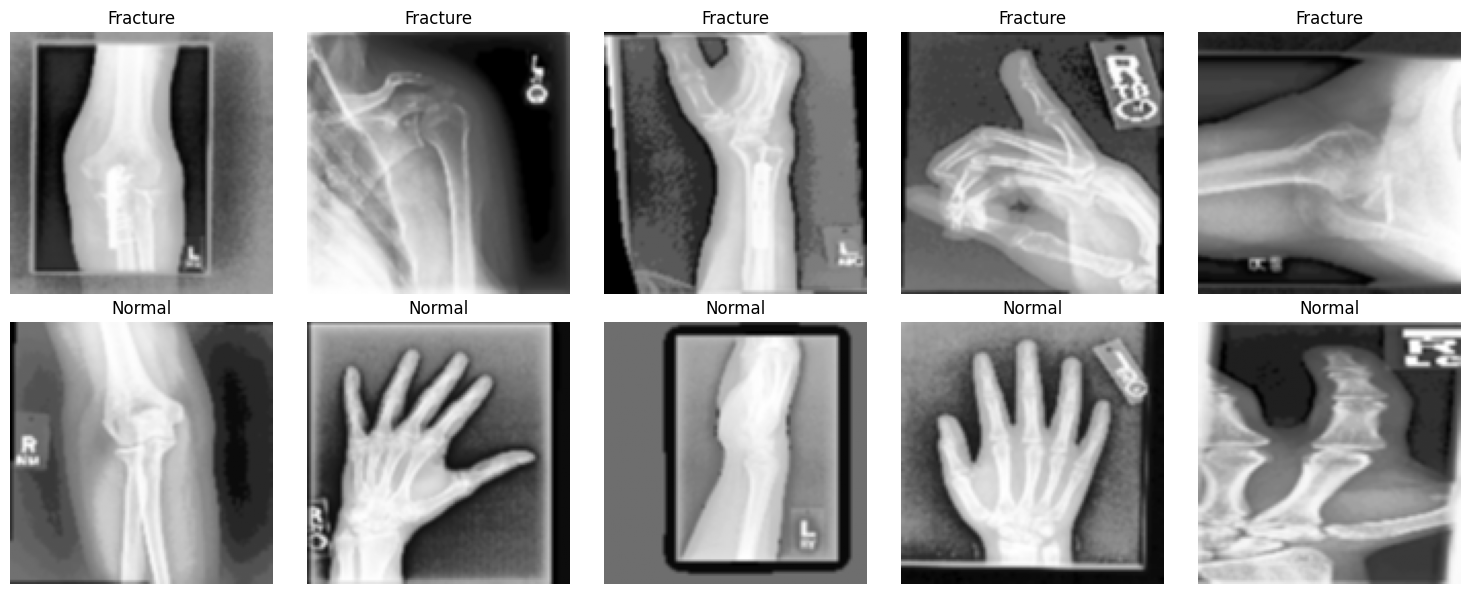

In [14]:
fracture_indices = np.where(y_train == 1)[0]
normal_indices = np.where(y_train == 0)[0]

fracture_samples = np.random.choice(fracture_indices, 5, replace=False)
normal_samples = np.random.choice(normal_indices, 5, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx in range(5):
    axes[0, idx].imshow(X_train_images[fracture_samples[idx]], cmap='gray')
    axes[0, idx].set_title('Fracture', fontsize=12)
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(X_train_images[normal_samples[idx]], cmap='gray')
    axes[1, idx].set_title('Normal', fontsize=12)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()

## Load Validation Data

In [15]:
valid_images_path = os.path.join(BASE_PATH, 'valid_image_paths.csv')
valid_labels_path = os.path.join(BASE_PATH, 'valid_labeled_studies.csv')

X_test_images, y_test = load_dataset(valid_images_path, valid_labels_path)
print(f"Loaded {len(X_test_images)} validation images")

Loading images...


  0%|          | 0/1199 [00:00<?, ?it/s]

100%|██████████| 1199/1199 [00:09<00:00, 125.34it/s]

Loaded 3197 validation images


In [16]:
train_counts = pd.Series(y_train).value_counts().reindex([0,1], fill_value=0)
valid_counts = pd.Series(y_test).value_counts().reindex([0,1], fill_value=0)
class_balance_df = pd.DataFrame({
    'Train Count': train_counts,
    'Train %': (train_counts / train_counts.sum() * 100).round(2),
    'Valid Count': valid_counts,
    'Valid %': (valid_counts / valid_counts.sum() * 100).round(2)
})
class_balance_df.index = ['Normal (0)','Fracture (1)']
print('Class Balance (Train vs Validation)')
print(class_balance_df.to_string())

Class Balance (Train vs Validation)
              Train Count  Train %  Valid Count  Valid %
Normal (0)          21935    59.59         1667    52.14
Fracture (1)        14873    40.41         1530    47.86


## Extract Features

In [ ]:
X_train = extract_features_from_images(X_train_images, feature_type='hog')
X_test = extract_features_from_images(X_test_images, feature_type='hog')
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Feature vector size: {X_train.shape[1]}")

Extracting HOG features...


 52%|█████▏    | 19296/36808 [01:27<01:13, 238.69it/s]

## Model Training and Evaluation

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'model': model_name,
        'model_object': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

## Train SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
linear_svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(C=1.0, max_iter=2000, random_state=42))
])
linear_svm_result = train_and_evaluate(X_train, X_test, y_train, y_test, 'Linear SVM (Scaled)', linear_svm_model)

## Train Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_result = train_and_evaluate(X_train, X_test, y_train, y_test, 'Random Forest', rf_model)

## Train K-Nearest Neighbors

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_result = train_and_evaluate(X_train, X_test, y_train, y_test, 'K-Nearest Neighbors', knn_model)

## Train Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_result = train_and_evaluate(X_train, X_test, y_train, y_test, 'Decision Tree', dt_model)

## Train Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
lr_result = train_and_evaluate(X_train, X_test, y_train, y_test, 'Logistic Regression (Scaled)', lr_model)

## Collect Results

In [ ]:
results = [linear_svm_result, rf_result, knn_result, dt_result, lr_result]

## Results Summary

In [ ]:
results_df = pd.DataFrame([
    {
        'Model': r['model'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1 Score': f"{r['f1_score']:.4f}"
    } for r in results
])

print("Model Performance Summary")
print(results_df.to_string(index=False))


Model Performance Summary
              Model Accuracy Precision Recall F1 Score
         Linear SVM   0.5924    0.5899 0.4869   0.5335
      Random Forest   0.6053    0.6861 0.3229   0.4391
K-Nearest Neighbors   0.6131    0.6348 0.4510   0.5273
      Decision Tree   0.5496    0.5330 0.4752   0.5024
Logistic Regression   0.6059    0.6148 0.4725   0.5344


## Confusion Matrices

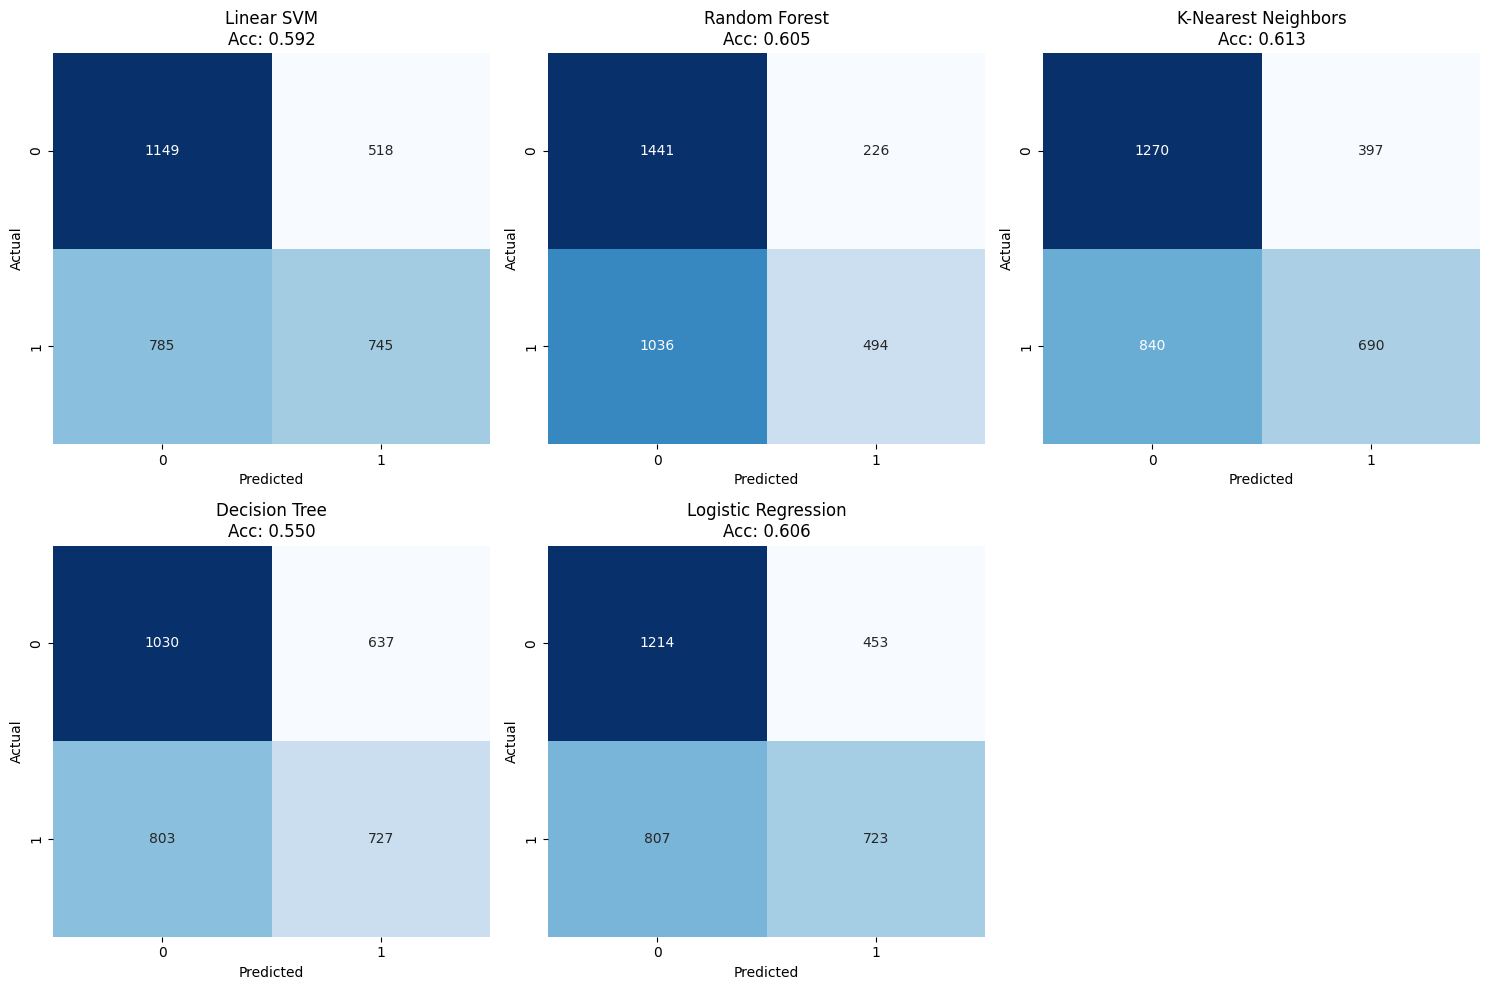

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, result in enumerate(results):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', 
                cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f"{result['model']}\nAcc: {result['accuracy']:.3f}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for idx in range(len(results), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance Comparison

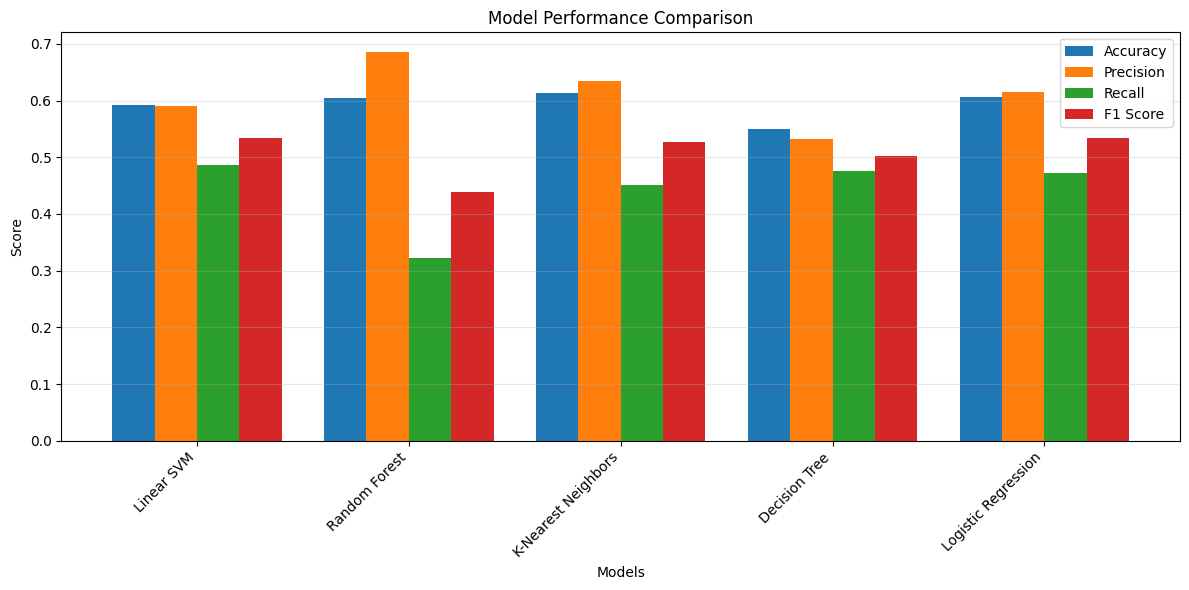

In [ ]:
models_names = [r['model'] for r in results]
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models_names))
width = 0.2

for idx, metric in enumerate(metrics):
    values = [r[metric] for r in results]
    ax.bar(x + idx * width, values, width, label=metric.replace('_', ' ').title())

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Best Model

In [ ]:
best_model = max(results, key=lambda x: x['f1_score'])
print(f"Best Performing Model: {best_model['model']}")
print(f"F1 Score: {best_model['f1_score']:.4f}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

Best Performing Model: Logistic Regression
F1 Score: 0.5344
Accuracy: 0.6059


## Sample Predictions

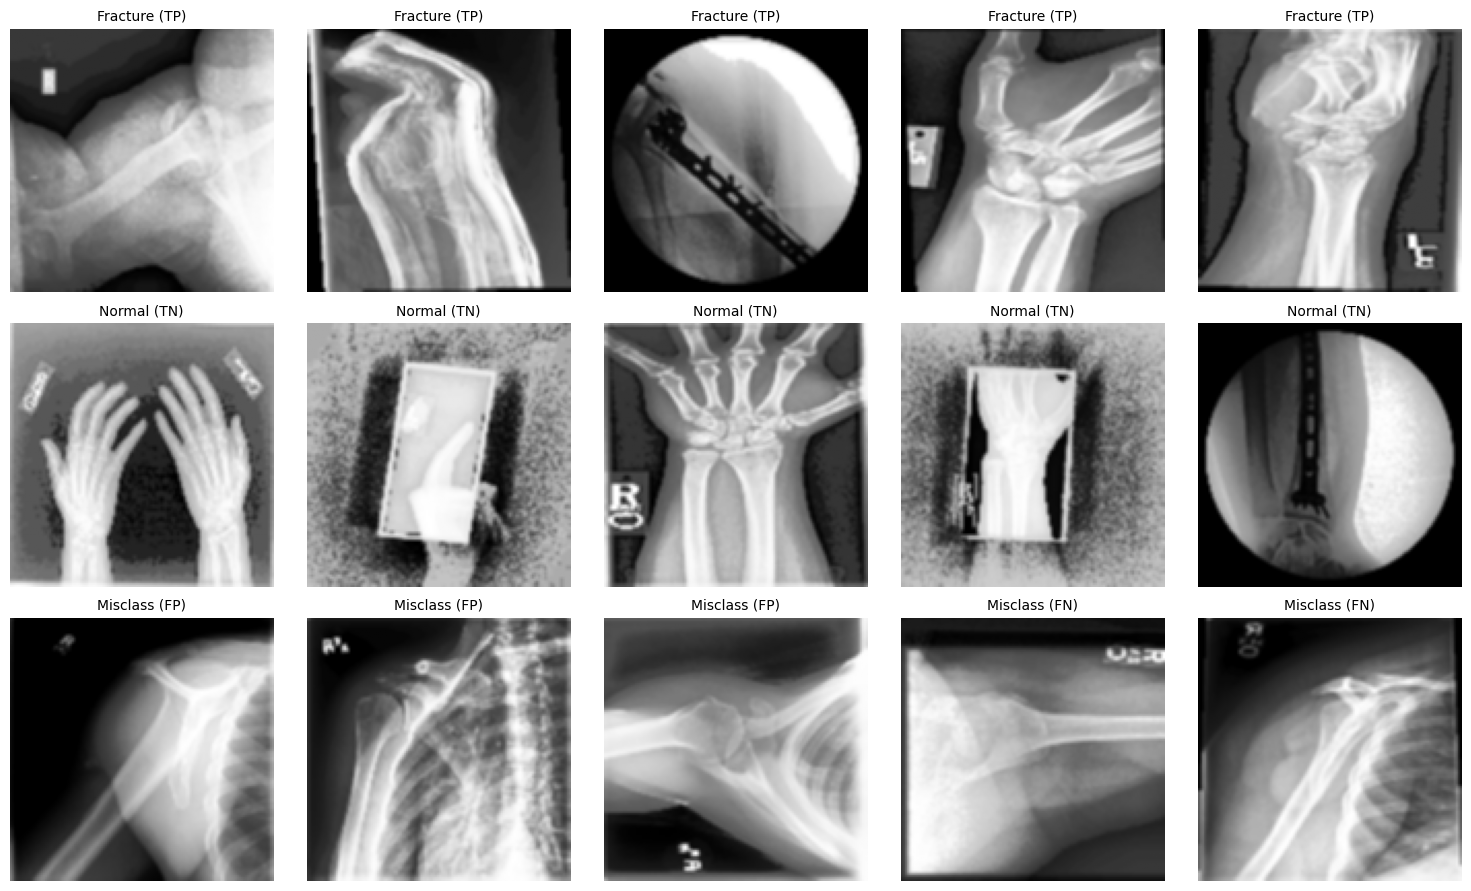

In [ ]:
best_model_obj = best_model['model_object']
n = 5
y_train_pred = best_model_obj.predict(X_train)
if hasattr(best_model_obj, 'decision_function'):
    raw_scores = best_model_obj.decision_function(X_train)
    if isinstance(raw_scores, np.ndarray) and raw_scores.ndim > 1:
        raw_scores = raw_scores[:, 1]
elif hasattr(best_model_obj, 'predict_proba'):
    raw_scores = best_model_obj.predict_proba(X_train)[:, 1]
else:
    raw_scores = np.ones(len(X_train))
tp_fracture = np.where((y_train == 1) & (y_train_pred == 1))[0]
tn_normal = np.where((y_train == 0) & (y_train_pred == 0))[0]
fp_indices = np.where((y_train == 0) & (y_train_pred == 1))[0]
fn_indices = np.where((y_train == 1) & (y_train_pred == 0))[0]
tp_fracture_sorted = tp_fracture[np.argsort(raw_scores[tp_fracture])[::-1]]
tn_normal_sorted = tn_normal[np.argsort(-raw_scores[tn_normal])]  
fracture_show = tp_fracture_sorted[:min(n, len(tp_fracture_sorted))]
normal_show = tn_normal_sorted[:min(n, len(tn_normal_sorted))]
misclassified = np.concatenate([fp_indices[:min(3, len(fp_indices))], fn_indices[:min(2, len(fn_indices))]])
rows = 3 if len(misclassified) > 0 else 2
fig, axes = plt.subplots(rows, n, figsize=(3*n, 3*rows))
if rows == 2:
    axes_tp = axes[0]
    axes_tn = axes[1]
else:
    axes_tp = axes[0]
    axes_tn = axes[1]
    axes_mis = axes[2]
for i in range(n):
    if i < len(fracture_show):
        axes_tp[i].imshow(X_train_images[fracture_show[i]], cmap='gray')
        axes_tp[i].set_title('Fracture (TP)', fontsize=10)
    axes_tp[i].axis('off')
for i in range(n):
    if i < len(normal_show):
        axes_tn[i].imshow(X_train_images[normal_show[i]], cmap='gray')
        axes_tn[i].set_title('Normal (TN)', fontsize=10)
    axes_tn[i].axis('off')
if rows == 3:
    for i in range(n):
        if i < len(misclassified):
            idx = misclassified[i]
            label_type = 'FP' if (y_train[idx] == 0 and y_train_pred[idx] == 1) else 'FN'
            axes_mis[i].imshow(X_train_images[idx], cmap='gray')
            axes_mis[i].set_title(f'Misclass ({label_type})', fontsize=10)
        axes_mis[i].axis('off')
plt.tight_layout()
plt.savefig('representative_examples.png', dpi=300, bbox_inches='tight')
plt.show()

## ROC and Classification Report

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
best_model_obj = best_model['model_object']
if hasattr(best_model_obj, 'predict_proba'):
    y_scores = best_model_obj.predict_proba(X_test)[:,1]
elif hasattr(best_model_obj, 'decision_function'):
    s = best_model_obj.decision_function(X_test)
    y_scores = s if s.ndim == 1 else s[:,1]
else:
    y_scores = None
if y_scores is not None:
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
    plt.legend(); plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
print(classification_report(y_test, best_model['predictions'], digits=3))

NameError: name 'best_model' is not defined

## Save Best Model

In [ ]:
import joblib
joblib.dump(best_model['model_object'], 'best_model.joblib')

## Threshold Sweep (F1 vs Threshold)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
best_model_obj = best_model['model_object']
if hasattr(best_model_obj, 'predict_proba'):
    y_scores = best_model_obj.predict_proba(X_test)[:,1]
elif hasattr(best_model_obj, 'decision_function'):
    s = best_model_obj.decision_function(X_test)
    y_scores = s if s.ndim == 1 else s[:,1]
else:
    y_scores = None
if y_scores is not None:
    thresholds = np.linspace(0.1, 0.9, 17)
    f1s = []
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        f1s.append(f1_score(y_test, y_pred_t))
    plt.figure(figsize=(7,4))
    plt.plot(thresholds, f1s, marker='o')
    plt.xlabel('Decision Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 vs Threshold (Validation)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('threshold_sweep.png', dpi=300, bbox_inches='tight')
    plt.show()
    best_idx = int(np.argmax(f1s))
    print(f'Best threshold={thresholds[best_idx]:.2f}, F1={f1s[best_idx]:.3f}')
else:
    print('Threshold sweep unavailable for models without scores')

## Stratified 5-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s = [], []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_va = X_train[train_idx], X_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    clf = lr_model
    clf.fit(X_tr, y_tr)
    y_va_pred = clf.predict(X_va)
    accs.append(accuracy_score(y_va, y_va_pred))
    f1s.append(f1_score(y_va, y_va_pred))
print(f'5-fold CV — Acc mean={np.mean(accs):.3f}±{np.std(accs):.3f}, F1 mean={np.mean(f1s):.3f}±{np.std(f1s):.3f}')